In [2]:
import numpy as np
import pymc3 as pm
import pickle
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
with open('weights_file.data', 'rb') as filehandle:
    # read the data as binary data stream
    weights_list = pickle.load(filehandle)

In [4]:
print(len(weights_list))

10


In [5]:
print(weights_list[0].shape)

(2, 256)


In [6]:
def nn(input):
    nh_layers = int(len(weights_list) / 2 - 2)
    xx = T.nnet.relu(pm.math.dot(weights_list[0].T, input) + weights_list[1])
    for hl in range(1, 1+nh_layers):
        xx = T.nnet.relu(pm.math.dot(weights_list[hl * 2].T, xx) + weights_list[hl * 2 + 1])
    xx = pm.math.dot(weights_list[-2].T, xx) + weights_list[-1]
    return xx.T

In [7]:
input = np.log10([1.0, 4.5])
print(np.array(10**nn(input).eval()))

[1.09877246e+00 5.91412798e+03]


In [8]:
import theano
model = pm.Model()
with model:
    lg_mass = pm.Normal('lg_mass', np.log10(1.2), 0.1)
    lg_age = pm.Normal('lg_age', np.log10(4.5), 0.2)
    
    obs = pm.Deterministic('obs', nn([lg_mass, lg_age]))
    
    obs_teff = pm.Normal('obs_teff', 10**obs[1], 70, observed=5912.0)
    obs_lum = pm.Normal('obs_lum', 10**obs[0], 0.1, observed=1.09)

In [9]:
inits = ['advi_map', 'adapt_diag']
start = {'lg_mass': np.log10(1.01), 'lg_age': np.log10(4.5)}

with model:
    trace = pm.sample(tune=5000, init=inits[1], start=start, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lg_age, lg_mass]
Sampling 4 chains: 100%|██████████| 22000/22000 [11:48<00:00, 31.07draws/s]
The number of effective samples is smaller than 25% for some parameters.


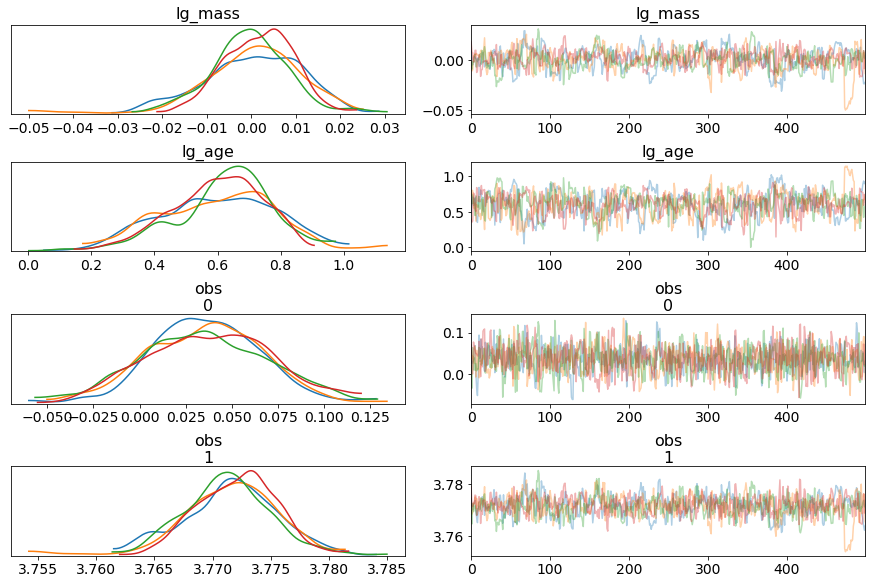

In [10]:
pm.traceplot(trace);

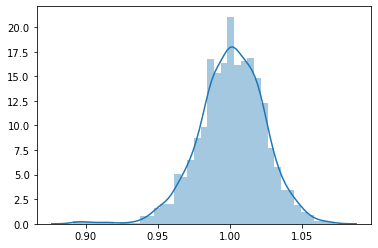

In [11]:
sns.distplot(10**trace['lg_mass'])

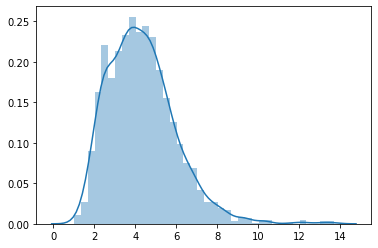

In [12]:
sns.distplot(10**trace['lg_age'])

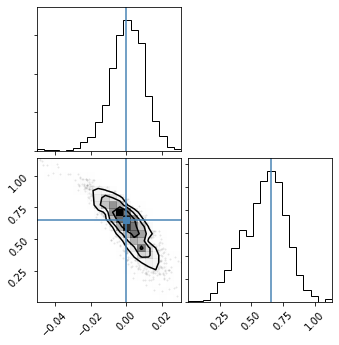

In [13]:
import corner
corner.corner(np.array([trace['lg_mass'], trace['lg_age']]).T, truths=[np.log10(1.0), np.log10(4.5)]);

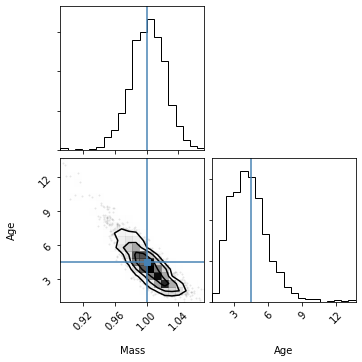

In [14]:
corner.corner(np.array([10**trace['lg_mass'], 10**trace['lg_age']]).T, truths=[1.0, 4.5],
             labels=['Mass', 'Age']);
plt.savefig('test_sun.png')